In [2]:
# SPDX-FileCopyrightText: Copyright (c) 2022-2023 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Self-Supervised Contrastive Learning with SimCLR for Surgical Data

* Dataset :    [Cholec80](http://camma.u-strasbg.fr/datasets) dataset (for the purpose of this walkthrough)
* Tutorial Adapted from : [Pytorch Lightning SSL](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/13-contrastive-learning.html) | [Github](https://www.github.com/PytorchLightning/pytorch-lightning/) 
* Other Key References : 
    1. [Ramesh et. al. : Dissecting Self-Supervised Learning Methods for Surgical Computer Vision](https://arxiv.org/abs/2207.00449) | [Github](https://github.com/CAMMA-public/SelfSupSurg) - for a more formal consideration of this topic


In this tutorial, we will take a closer look at self-supervised contrastive learning.
Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way.
However, this data still contains a lot of information from which we can learn: how are the images different from each other?
What patterns are descriptive for certain images?
Can we cluster the images?
To get an insight into these questions, we will implement a popular, simple contrastive learning method, SimCLR, and apply it to data from cholecystectomy surgeries.

## Setup
This notebook requires some packages besides pytorch-lightning.

## Create Docker Image/Container

```bash
DATA_DIR="/mnt/sdb/data"
docker build -t surg_video_ssl:latest Docker/

# sample Docker command
docker run -it ---gpus="device=1" \
    --name=SURGSSL_EXPS \
    -v $DATA_DIR:/workspace/data \
    -v `pwd`:/workspace/codes -w=/workspace/codes/ -p 8888:8888 \
    --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 \
    surg_video_ssl jupyter lab
```

For environment dependencies refer to the [Dockerfile](Docker/Dockerile)

Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific downstream task (classification/regression/segmentation etc). The key benefit of self-supervised learning is that a large "unannotated" dataset can often easily be obtained (frames from a video/web crawl etc.).  

For instance, if we want to train a vision model on semantic segmentation for surgery; a lot of data is already collected within operating rooms today sometimes totalling hours or surgery. 
In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive especially in a healthcare setting. 
Self-supervised learning can furthermore provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. recording of the surgery room vs recording of the surgery itself.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available.
The subfield that we will focus on in this tutorial is contrastive learning.
Contrastive learning is motivated by the question mentioned above: how are images different from each other?
Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized.
A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al. ](https://simclr.github.io/)).

<p align="center">
  <img src="https://1.bp.blogspot.com/--vH4PKpE9Yo/Xo4a2BYervI/AAAAAAAAFpM/vaFDwPXOyAokAC8Xh852DzOgEs22NhbXwCLcBGAsYHQ/s640/image4.gif" />
</p>


### Summary of the training steps

The general idea is that we have a set of images without any labels, and want to train a model on this data such that it learns a generic 'representation' of the data.
During each training iteration, we sample a batch of images as usual.
For each image, we create two versions by applying data augmentation.

On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP.
The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible.
This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

In [1]:
import os
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
import json
import csv
import numpy as np

plt.set_cmap("cividis")
%matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = ("/workspace/data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = ("/workspace/data/models/")
# Select all CPU cores for I/O Data Preprocessing
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") # Assuming GPUs are available
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/home/clara/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_452682/2323381369.py:26: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export
Global seed set to 42


Device: cuda:0
Number of workers: 76


## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such.
Next, we implement SimCLR with PyTorch Lightning, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch.
The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.
This is implemented in the class `ContrastiveTransformations` below:

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image.
However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply.
The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.
Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

Although surgical scenes are different in content and color distribution, for the purposes of this tutorial, similar augmentations can be used. For a more detailed consideration of Augmentation for Surgical video, please refer to [ [4](https://arxiv.org/abs/2207.00449)].


In [19]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=224),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

## Dataset 

After discussing the data augmentation techniques, we can now focus on the dataset.

In these experiments, we focused on an internal dataset not dissimilar from the publicly available [Cholec80](http://camma.u-strasbg.fr/datasets), which consists of frames extract at `1 fps` from roughly ~250 cholecystectomy videos ( ~ 1 M frames). Each frame was resampled to a size of $256\times 256$. This dataset is used for "pre-training" our model.

We can request for the [Cholec80](http://camma.u-strasbg.fr/datasets), frames can be extracted using the python helper file as follows:

`python extract_frames.py --datadir <path_to_cholec80_dataset>` 

## Pytorch Dataloader/Dataset Surgical Frames Dataset

Dataloader below are designed to read from a `CSV` file formatted as follows:

```
<path_to_frame>,<label>
```
where `<label>` can be a class/score for a downstream task, and is NOT used during pre-training.

```
/workspace/data/cholec80/frames/train/video01/1.jpg,0
/workspace/data/cholec80/frames/train/video01/2.jpg,0
/workspace/data/cholec80/frames/train/video01/3.jpg,0
/workspace/data/cholec80/frames/train/video01/4.jpg,0
/workspace/data/cholec80/frames/train/video01/5.jpg,0
....
```


As this section focuses on contrastive learning *without* any annotations, we will define our data loader accordingly. Using the `contrastive_learning` flag we can chose whether the labels are being loaded or not. We have provided a `"sample_csv.csv"` along with this guide as an example. 

In [17]:
from PIL import Image
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class SurgicalVisionDataset_json(data.Dataset):
    def __init__(self, csv_path, transform=None, contrastive_training=True,
                 loader=pil_loader):
        with open(csv_path, 'r') as csv_file:
            self.img_labels = list(csv.reader(csv_file, delimiter=','))
        self.transform = transform
        self.loader = loader
        self.return_labels = not contrastive_training

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = self.img_labels[index][0]
        image = self.loader(img_path)
#         labels_phase = self.file_labels_phase[index]
        if self.transform is not None:
            image = self.transform(image)

        if self.return_labels:
            label = self.img_labels[index][1]
            return image, label

        return image, index


In [23]:
unlabeled_data = SurgicalVisionDataset_json(csv_path="sample_csv.csv",
                                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Finally, before starting with our implementation of SimCLR, let's look
at some example image pairs sampled with our augmentations:

Global seed set to 42


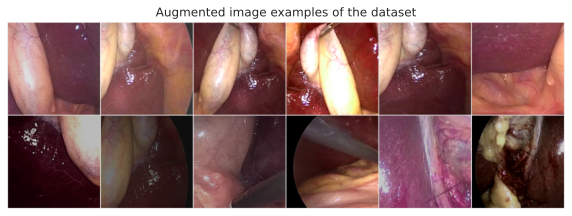

In [24]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion.
Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR.
At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$.
Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch.
The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$.
The base network is usually a deep CNN, and is responsible for extracting a representation vector from the augmented data examples.
In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$.
The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors.
It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.
Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably.
This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset.
The general setup is visualized below (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.
The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task.
This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks.
Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model.
As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch.
SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al. ](https://arxiv.org/abs/1807.03748) for contrastive learning.
In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values.
The loss can be formally written as:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is.
Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch.
The similarity metric that is used in SimCLR is cosine similarity, as defined below:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.
In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [9]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            pretrained=False, num_classes=4 * hidden_dim
        )  # num_classes is the output size of the last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)
        # Get ranking position of positive example
        comb_sim = torch.cat(
            [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
            dim=-1,
        )
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that.
However, in this tutorial, we will restrict ourselves to the STL10
dataset where we use the task of image classification on STL10 as our
test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.
We will use the same training function setup as usual.
For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch.
This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [10]:
def train_simclr(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        gpus=1 if str(device) == "cuda:0" else 0,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_loss"),
            LearningRateMonitor("epoch"),
        ],
    )
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SurgicalVision_SimCLR_ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        dataset_size = len(unlabeled_data)
        dataset_indices = list(range(dataset_size))
        np.random.seed(42)
        np.random.shuffle(dataset_indices)
        val_split_index = int(np.floor(0.2 * dataset_size))
        train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
        train_sampler = data.SubsetRandomSampler(train_idx)
        val_sampler = data.SubsetRandomSampler(val_idx)


        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
            sampler=train_sampler
        )
        val_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
            sampler=val_sampler
        )
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform.
A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients.
However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [11]:
simclr_model = train_simclr(
    batch_size=256, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=10
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at /home/clara/activ/models/test_checkpoints/SurgicalVision_SimCLR_ResNet.ckpt, loading...


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [12]:
%tensorboard --logdir os.path.join(CHECKPOINT_PATH, "SimCLR")

## Fine-tuning /Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data.
A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features.
In other words, we learn a single, linear layer that maps the representations to a class prediction.
Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task.
Further, we do not have to worry too much about overfitting since we have very few parameters that are trained.
Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors.
If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations.
However, the way we implement it here is much more efficient and can be trained within a few seconds.
Further, using data augmentations did not show any significant gain in this simple setup.

In [12]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

As an example: the data we use here is the Cholec80 data. We organized the data in-line with MONAI/Medical Decathlon dataset `json`. This roughly gets arranged as follows - 

Along with the tutorial, we are providing access to the `json` [file we created for the cholec80 dataset](https://drive.google.com/file/d/1HyX3kT0I4EH08JiybkfBtFzAo-jvGKFU/view?usp=drive_link) to simplify running through the remainder of the tutorial.

```
"training": [
        {
            "image": "/workspace/data/cholec80/cholec80/1/0.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        {
            "image": "/workspace/data/cholec80/cholec80/1/1.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        ... ... ...
"validation": [
        {
            "image": "/workspace/data/cholec80/cholec80/41/0.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        {
            "image": "/workspace/data/cholec80/cholec80/41/1.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        ... ... ...
"test": [
        {
            "image": "/workspace/data/cholec80/cholec80/61/0.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        {
            "image": "/workspace/data/cholec80/cholec80/61/1.jpg",
            "phase_label": 0,
            "tool_label": [1,0,0,0,0,0,0]
        },
        ... ... ...
```


In [13]:
class CholecDataset_json(data.Dataset):
    def __init__(self, json_path, transform=None, contrastive_training=True,
                 split="training", loader=pil_loader):
        with open(json_path, 'r') as f:
            self.info = json.load(f)
        self.transform = transform
        self.loader = loader
        self.return_labels = not contrastive_training
        self.split = split

    def __getitem__(self, index):
        img_names = self.info[self.split][index]['image']
#         labels_phase = self.file_labels_phase[index]
        imgs = self.loader(img_names)
        if self.transform is not None:
            imgs = self.transform(imgs)

        if self.return_labels:
            labels = self.info["training"][index]["phase_label"]
            return imgs, labels

        return imgs, index

    def __len__(self):
        return len(self.info[self.split])

img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_img_data = CholecDataset_json(json_path=DATASET_PATH+"cholec80/cholec80.json",
                                            contrastive_training = False,
                                            transform=img_transforms)

test_img_data = CholecDataset_json(json_path=DATASET_PATH+"cholec80/cholec80.json",          
                                            contrastive_training = False,
                                            split="testing",
                                            transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Number of training examples: 136668
Number of test examples: 47625


Next, we implement a small function to encode all images in our datasets.
The output representations are then used as inputs to the Logistic Regression model.

In [16]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in data_loader:
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [17]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Finally, we can write a training function as usual.
We evaluate the model on the test set every 10 epochs to allow early
stopping, but the low frequency of the validation ensures that we do not
overfit too much on the test set.

In [29]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression_Surg"),
        gpus=1 if str(device) == "cuda:0" else 0,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
#         progress_bar_refresh_rate=0,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_Surg_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [26]:
feats, labels = train_feats_simclr.tensors
class_idx = [[idx for idx in range(len(feats)) if labels[idx] == cl] for cl in range(7)]
shuff = [np.random.shuffle(ll) for ll in class_idx]
class_idx_4000 = torch.cat([torch.tensor(ll[:4000]) for ll in class_idx])
subset_train_feats_balanced = data.TensorDataset(feats[class_idx_4000,:],labels[class_idx_4000]) 



Here will perform experiments by fine-tuning on $1\%, 10\%$ or $100\%$ of the samples. In this case, the least represented class has ~ 20000 samples in total.This task gives us an intuition on how well the representations learned by contrastive learning can be transferred to a image recognition task like this classification.
First, let's define a function to create the intended sub-datasets from the full training set:~~

In [27]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *(t.unflatten(0, (7, 4000))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

In [36]:
results = {}
print('Finetuning with (1,10,100)% data...')

pre_calc_data_size = {
    1: 200,
    10: 2000,
    100: 'all'
}

for perc in list(pre_calc_data_size.keys()):
    num_imgs_per_label = pre_calc_data_size[perc]
    if num_imgs_per_label == 'all':
        sub_train_set = train_feats_simclr
    else:            
        sub_train_set = get_smaller_dataset(subset_train_feats_balanced, num_imgs_per_label)
    print(f'Length sub_train_set {len(sub_train_set)}')
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=perc,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=7,
        lr=1e-3,
        weight_decay=1e-3,
        max_epochs=100,
    )

    # print(small_set_results)
    ## Save Results
    # write_results_to_csv("./results_simclr_finetune.csv")

    results[perc] = small_set_results

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 3.6 K 
---------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Finetuning with (1,10,100)% data...
Length sub_train_set 1400
                                                              

/home/clara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/clara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/clara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower val

Epoch 99: 100%|██████████| 767/767 [00:01<00:00, 607.69it/s, loss=0.701, v_num=4]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/clara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/home/clara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing: 100%|██████████| 22/22 [00:00<00:00, 597.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Testing: 100%|██████████| 745/745 [00:01<00:00, 665.30it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 3.6 K 
---------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)



Length sub_train_set 14000
                                                              

Global seed set to 42


Epoch 99: 100%|██████████| 964/964 [00:02<00:00, 440.15it/s, loss=0.689, v_num=5]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Testing: 100%|██████████| 219/219 [00:00<00:00, 625.36it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Testing: 100%|██████████| 745/745 [00:01<00:00, 634.13it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 3.6 K 
---------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)



Length sub_train_set 136668
                                                              

Global seed set to 42


Epoch 99: 100%|██████████| 2881/2881 [00:10<00:00, 273.69it/s, loss=0.61, v_num=6]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Testing: 100%|██████████| 2136/2136 [00:03<00:00, 639.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



Testing: 100%|██████████| 745/745 [00:01<00:00, 652.40it/s]


### Sample Result
Pre-training with Activ-Surgical data and fine-tuning within different \%s of data for single-frame based phase classfication on Cholec80 Dataset.

![Results_ResNet18](images/Results_ResNet18_ex.png)

As we can see here, even with a few samples of the annotated dataset, and we are able to do better than than a fully supervised approach with ease. Using a 100% of the data on top of a self-supervised backbone can also give help improve the overall performance when compared to an image net backbone. 

The [included script](./train_simclr_multigpu.py), adapts the similar workflow and makes it easy to run it on multiple GPUs. It also adds support for more backbones and can be easily extended more architectures/datasets.
Another downstream application is that of surgical tool segmentation. In the [example script](./downstream_task_tool_segmentation.py), we load a model trained using SelfSupervised learning and train a "UNet" style model for tool segmentation. We see benefits of using a SSL pre-trained backbone there as well. 

For a more in-depth consideration of SSL with Surgical Vision data, please refer to [4].

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020).
A simple framework for contrastive learning of visual representations.
In International conference on machine learning (pp.
1597-1607).
PMLR.
([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020).
Big self-supervised models are strong semi-supervised learners.
NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O.
(2018).
Representation learning with contrastive predictive coding.
arXiv preprint arXiv:1807.03748.
([link](https://arxiv.org/abs/1807.03748))

[4] Ramesh, S., Srivastav, V., Alapatt, D., Yu, T., Muarli, A., et. al. (2023).   
Dissecting Self-Supervised Learning Methods for Surgical Computer Vision.
arXiv preprint arXiv:2207.00449.
([link](https://arxiv.org/abs/2207.00449))
